# Correlations shipping experiment

In [1]:
import os
import qiime2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the working directory
wd = '/Users/meyeanni/Desktop/git_sourdough/SourdoughFlow/LP4/shipping_analysis/shipping_data'

# Change to the working directory
os.chdir(wd)

# Verify current working directory
print("Current working directory:", os.getcwd())

Current working directory: /Users/meyeanni/Desktop/git_sourdough/SourdoughFlow/LP4/shipping_analysis/shipping_data


In [2]:
#import this csv: 20250521_shipping_metadata_with_absolute_16S_species_data.csv:
# Read the CSV file into a DataFrame
df = pd.read_csv('20250521_shipping_metadata_with_absolute_16S_species_data.csv', index_col=0)

In [3]:
df.columns.to_list()

['Unnamed: 0',
 'Chao1 kmers ITS',
 'Chao1 OTUs ITS',
 'Chao1 ASVs ITS',
 'Chao1 kmers',
 'Chao1 OTUs',
 'Chao1 ASVs',
 'identifier',
 'row',
 'column',
 'temperature',
 'day',
 'replicate',
 'well',
 'DNA yield',
 'DNA_total_yield_per_1g',
 'pH',
 'TTA',
 'estimate_bact',
 'estimate_bact_CFUs',
 'LAB CFUs',
 'LAB_counts',
 'bac_diff',
 'yeast CFUs',
 'mannitol',
 'glucose',
 'fructose',
 'sucrose',
 'maltose',
 'succinic acid',
 'lactic acid',
 'acetic acid',
 'ethanol',
 'Observed features ASVs',
 'Observed features OTUs',
 'Observed features kmers',
 'Shannon ASVs',
 'Evenness ASVs',
 'Simpson ASVs',
 'Shannon OTUs',
 'Evenness OTUs',
 'Simpson OTUs',
 'Shannon kmers',
 'Evenness kmers',
 'Simpson kmers',
 'color',
 'color2',
 'Observed features ASVs ITS',
 'Observed features OTUs ITS',
 'Observed features kmers ITS',
 'Shannon ASVs ITS',
 'Evenness ASVs ITS',
 'Simpson ASVs ITS',
 'Shannon OTUs ITS',
 'Evenness OTUs ITS',
 'Simpson OTUs ITS',
 'Shannon kmers ITS',
 'Evenness kmers 

In [5]:
import numpy as np
#first log-transform a selection of columns:
# Select the columns to log-transform
cols_to_log_transform = [
    'mannitol',
 'glucose',
 'fructose',
 'sucrose',
 'maltose',
 'succinic acid',
 'lactic acid',
 'acetic acid',
 'ethanol'
]
# Log-transform the selected columns
df[cols_to_log_transform] = df[cols_to_log_transform].apply(lambda x: x + 1).apply(np.log10)

In [6]:
selected_vars = ['log10_Acetobacter cerevisiae',
 'log10_Lactobacillus sanfranciscensis',
 'log10_Pediococcus parvulus',
 'log10_Lactobacillus rossiae',
 'log10_Lactobacillus brevis',
 'log10_estimate_bact','yeast CFUs',
 'mannitol',
 'glucose',
 'fructose',
 'sucrose',
 'maltose',
 'succinic acid',
 'lactic acid',
 'acetic acid',
 'ethanol','LAB CFUs','pH',
 'TTA','DNA yield','temperature',
 'day']

In [48]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.stats.multitest import multipletests

# Function to calculate cosine similarity for two numeric vectors
def cosine_similarity_numeric(series1, series2):
    s1 = series1.values.reshape(1, -1)
    s2 = series2.values.reshape(1, -1)
    return cosine_similarity(s1, s2)[0, 0]

# threshold = 0.6  # Maximum allowed fraction of NaNs in any column
# md_copy = df_flavour_category_corr.dropna(axis=1, thresh=int((1 - threshold) * len(df_flavour_category_corr)))

# After dropping columns with high NaN percentages, update numeric_vars
md_copy = df[selected_vars].copy()
numeric_vars = md_copy.columns.to_list()

min_sample_size = 2  # Minimum number of non-NaN samples for correlation
epsilon = 1e-8  # Small value to prevent division by zero



# Initialize matrices for correlation coefficients and p-values
pearson_corr_matrix = pd.DataFrame(index=numeric_vars, columns=numeric_vars, dtype=float)
pearson_pval_matrix = pd.DataFrame(index=numeric_vars, columns=numeric_vars, dtype=float)
spearman_corr_matrix = pd.DataFrame(index=numeric_vars, columns=numeric_vars, dtype=float)
spearman_pval_matrix = pd.DataFrame(index=numeric_vars, columns=numeric_vars, dtype=float)
cosine_sim_matrix = pd.DataFrame(index=numeric_vars, columns=numeric_vars, dtype=float)

# Lists to store raw p-values for FDR correction
p_values_pearson = []  # (var1, var2, raw p-value)
p_values_spearman = []


for var1 in numeric_vars:
    for var2 in numeric_vars:
        if var1 == var2:
            pearson_corr_matrix.loc[var1, var2] = 1
            spearman_corr_matrix.loc[var1, var2] = 1
            cosine_sim_matrix.loc[var1, var2] = 1
            continue

        filtered_md = md_copy[[var1, var2]].dropna()
        if len(filtered_md) < min_sample_size or filtered_md[var1].var() == 0 or filtered_md[var2].var() == 0:
            continue

        # Pearson Correlation
        pearson_corr, pearson_p = pearsonr(filtered_md[var1], filtered_md[var2])
        p_values_pearson.append((var1, var2, pearson_p))
        pearson_corr_matrix.loc[var1, var2] = pearson_corr
        pearson_corr_matrix.loc[var2, var1] = pearson_corr

        # Spearman Correlation
        spearman_corr, spearman_p = spearmanr(filtered_md[var1], filtered_md[var2])
        p_values_spearman.append((var1, var2, spearman_p))
        spearman_corr_matrix.loc[var1, var2] = spearman_corr
        spearman_corr_matrix.loc[var2, var1] = spearman_corr

        # Cosine Similarity
        norm1 = np.linalg.norm(filtered_md[var1])
        norm2 = np.linalg.norm(filtered_md[var2])
        if norm1 < epsilon or norm2 < epsilon:
            cosine_sim = np.nan
        else:
            cosine_sim = cosine_similarity_numeric(filtered_md[var1], filtered_md[var2])
        cosine_sim_matrix.loc[var1, var2] = cosine_sim
        cosine_sim_matrix.loc[var2, var1] = cosine_sim
# Initialize raw p-value matrix
pearson_raw_pval_matrix = pd.DataFrame(index=pearson_corr_matrix.index, columns=pearson_corr_matrix.columns)

spearman_raw_pval_matrix = pd.DataFrame(index=spearman_corr_matrix.index, columns=spearman_corr_matrix.columns)
# FDR-corrected and raw
if p_values_pearson:
    p_vals_only = [p[2] for p in p_values_pearson]
    rejected, corrected_pvals, _, _ = multipletests(p_vals_only, method='fdr_bh')
    for (var1, var2, raw_p), p_corrected, reject in zip(p_values_pearson, corrected_pvals, rejected):
        # Corrected
        pearson_pval_matrix.loc[var1, var2] = p_corrected
        pearson_pval_matrix.loc[var2, var1] = p_corrected
        # Raw
        pearson_raw_pval_matrix.loc[var1, var2] = raw_p
        pearson_raw_pval_matrix.loc[var2, var1] = raw_p

if p_values_spearman:
    p_vals_only = [p[2] for p in p_values_spearman]
    rejected, corrected_pvals, _, _ = multipletests(p_vals_only, method='fdr_bh')
    for (var1, var2, _), p_corrected, reject in zip(p_values_spearman, corrected_pvals, rejected):
        spearman_pval_matrix.loc[var1, var2] = p_corrected
        spearman_pval_matrix.loc[var2, var1] = p_corrected
        # Raw
        spearman_raw_pval_matrix.loc[var1, var2] = raw_p
        spearman_raw_pval_matrix.loc[var2, var1] = raw_p

# Fill NaNs with non-significant values for matrices
pearson_pval_matrix = pearson_pval_matrix.fillna(1)
spearman_pval_matrix = spearman_pval_matrix.fillna(1)
cosine_sim_matrix = cosine_sim_matrix.fillna(0)

np.fill_diagonal(pearson_corr_matrix.values, 1)
np.fill_diagonal(spearman_corr_matrix.values, 1)
np.fill_diagonal(cosine_sim_matrix.values, 1)

# Display results
print("Pearson Correlation Matrix:")
print(pearson_corr_matrix)

print("Spearman Correlation Matrix:")
print(spearman_corr_matrix)

print("Cosine Similarity Matrix:")
print(cosine_sim_matrix)

print("Corrected Pearson p-values Matrix:")
print(pearson_pval_matrix)

print("Corrected Spearman p-values Matrix:")
print(spearman_pval_matrix)

# Initialize a results list for pairwise comparisons
results = []

# Extract pairwise results into a list
for var1 in numeric_vars:
    for var2 in numeric_vars:
        if var1 == var2:
            continue  # Skip self-comparisons

        pearson_corr = pearson_corr_matrix.loc[var1, var2]
        spearman_corr = spearman_corr_matrix.loc[var1, var2]
        cosine_sim = cosine_sim_matrix.loc[var1, var2]

        # Retrieve p-values (fill with NaN if not available)
        pearson_uncorrected = next((p[2] for p in p_values_pearson if (p[0] == var1 and p[1] == var2) or (p[0] == var2 and p[1] == var1)), np.nan)
        spearman_uncorrected = next((p[2] for p in p_values_spearman if (p[0] == var1 and p[1] == var2) or (p[0] == var2 and p[1] == var1)), np.nan)
        
        pearson_pval_corrected = pearson_pval_matrix.loc[var1, var2]
        spearman_pval_corrected = spearman_pval_matrix.loc[var1, var2]

        # Append results
        results.append({
            'Variable 1': var1,
            'Variable 2': var2,
            'Pearson Correlation': pearson_corr,
            'Spearman Correlation': spearman_corr,
            'Cosine Similarity': cosine_sim,
            'Uncorrected Pearson P-Value': pearson_uncorrected,
            'Corrected Pearson P-Value': pearson_pval_corrected,
            'Uncorrected Spearman P-Value': spearman_uncorrected,
            'Corrected Spearman P-Value': spearman_pval_corrected
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df
# Save results to CSV
#results_df.to_csv('20250227_pairwise_correlation_results_num_vars_with_lat_lon.csv', index=False)

# # Save matrices for further processing
# pearson_corr_matrix.to_csv('pearson_corr_matrix.csv')
# spearman_corr_matrix.to_csv('spearman_corr_matrix.csv')
# cosine_sim_matrix.to_csv('cosine_sim_matrix.csv')
# pearson_pval_matrix.to_csv('corrected_pearson_pval_matrix.csv')
# spearman_pval_matrix.to_csv('corrected_spearman_pval_matrix.csv')



Pearson Correlation Matrix:
                                      log10_Acetobacter cerevisiae  \
log10_Acetobacter cerevisiae                              1.000000   
log10_Lactobacillus sanfranciscensis                     -0.223654   
log10_Pediococcus parvulus                                0.403026   
log10_Lactobacillus rossiae                               0.162100   
log10_Lactobacillus brevis                                0.221482   
log10_estimate_bact                                      -0.087115   
yeast CFUs                                               -0.332001   
mannitol                                                 -0.238970   
glucose                                                  -0.187691   
fructose                                                  0.085190   
sucrose                                                  -0.134879   
maltose                                                  -0.114399   
succinic acid                                             0.08

,Variable 1,Variable 2,Pearson Correlation,Spearman Correlation,Cosine Similarity,Uncorrected Pearson P-Value,Corrected Pearson P-Value,Uncorrected Spearman P-Value,Corrected Spearman P-Value
0,log10_Acetobacter cerevisiae,log10_Lactobacillus sanfranciscensis,-0.223654,-0.194884,0.979143,3.115809e-02,6.854780e-02,6.121084e-02,1.104664e-01
1,log10_Acetobacter cerevisiae,log10_Pediococcus parvulus,0.403026,0.320691,0.963649,6.192940e-05,3.668126e-04,1.724305e-03,5.172916e-03
2,log10_Acetobacter cerevisiae,log10_Lactobacillus rossiae,0.162100,-0.016086,0.972727,1.205722e-01,2.047954e-01,8.783701e-01,9.317651e-01
3,log10_Acetobacter cerevisiae,log10_Lactobacillus brevis,0.221482,0.258526,0.933205,3.287694e-02,6.947587e-02,1.234555e-02,2.716020e-02
4,log10_Acetobacter cerevisiae,log10_estimate_bact,-0.087115,0.058373,0.981379,4.063547e-01,5.186074e-01,5.783516e-01,7.106342e-01
...,...,...,...,...,...,...,...,...,...
457,day,LAB CFUs,-0.363700,-0.570730,0.728911,3.390155e-04,1.483502e-03,2.330509e-09,2.563560e-08
458,day,pH,0.033599,0.179196,0.749729,7.491794e-01,8.012057e-01,8.567412e-02,1.434110e-01
459,day,TTA,0.622038,0.701853,0.840464,2.831203e-11,5.450066e-10,4.611367e-15,1.183584e-13
460,day,DNA yield,-0.073011,-0.219217,0.589150,4.867450e-01,5.766056e-01,3.475389e-02,6.580449e-02


In [49]:
pwd

'/Users/meyeanni/Desktop/git_sourdough/SourdoughFlow/LP4/shipping_analysis/shipping_data'

In [50]:
#export the results_df to a csv file
results_df.to_csv('Stats/20250521_pairwise_correlation_results_CFU_HPLC_pH_TTA_bacterial_species_qPCR.csv', index=False)

plot with clusters based on subselected x and y variables:

In [72]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np

def plot_clustered_bubbleplot_with_dendrograms(corr_matrix, pval_matrix, raw_pval_matrix = None,
                                               x_vars=None, y_vars=None,
                                               alpha_cutoff=0.05,
                                               method='average', metric='euclidean',
                                               figsize=(16, 14),
                                               pos_color="#CB6BCEFF",
                                               neg_color="#345084FF",
                                               title='Clustered Correlation Bubble Plot',
                                               max_bubble_size=600,
                                               fontsize=12,
                                               rename_dict=None):
    """
    Bubble plot with hierarchical clustering and displayed dendrograms.
    - Bubble size ~ |correlation|
    - Color = direction
    - Alpha = significance
    """

    # Subset to selected vars
    if x_vars is not None:
        corr_matrix = corr_matrix[x_vars]
        pval_matrix = pval_matrix[x_vars]
    if y_vars is not None:
        corr_matrix = corr_matrix.loc[y_vars]
        pval_matrix = pval_matrix.loc[y_vars]

    # For clustering, fill NaNs with 0 (safe for ordering, not used in display)
    clustering_corr = corr_matrix.fillna(0)

    # Linkages
    row_linkage = linkage(pdist(clustering_corr.values, metric=metric), method=method)
    col_linkage = linkage(pdist(clustering_corr.values.T, metric=metric), method=method)

    row_order = corr_matrix.index[leaves_list(row_linkage)]
    col_order = corr_matrix.columns[leaves_list(col_linkage)]

    # Reorder matrices
    corr_matrix = corr_matrix.loc[row_order, col_order]
    pval_matrix = pval_matrix.loc[row_order, col_order]

    # Prepare plot data
    data = []
    for y in corr_matrix.index:
        for x in corr_matrix.columns:
            r = corr_matrix.loc[y, x]
            p = pval_matrix.loc[y, x]
            raw_p = raw_pval_matrix.loc[y, x] if raw_pval_matrix is not None else p

            if pd.isna(raw_p):
                alpha = 0.0
                if r >= 0:
                    edgecolor = pos_color
                else:
                    edgecolor = neg_color
                
            elif raw_p >= alpha_cutoff:
                alpha = 0.3
                if r >= 0:
                    edgecolor = pos_color
                else:
                    edgecolor = neg_color
                
            else:
                if p < alpha_cutoff:
                    alpha = 1.0
                    edgecolor = 'cyan'
                else:
                    alpha = 1.0
                    if r >= 0:
                        edgecolor = pos_color
                    else:
                        edgecolor = neg_color
                    

            if pd.notna(r):
                data.append({
                    'x': x,
                    'y': y,
                    'r': r,
                    'abs_r': abs(r),
                    'alpha': alpha,
                    'edgecolor': edgecolor,
                    'color': pos_color if r >= 0 else neg_color
                })


    df_plot = pd.DataFrame(data)

    # Set up grid
    fig = plt.figure(figsize=figsize)
    spec = gridspec.GridSpec(2, 2, width_ratios=[1, 4], height_ratios=[1, 4],
                             wspace=0.7, hspace=0.05)

        # Column dendrogram (top)
    ax_col_dendro = fig.add_subplot(spec[0, 1])
    dendro_col = dendrogram(
        col_linkage,
        labels=col_order,
        ax=ax_col_dendro,
        color_threshold=None,
        orientation='top',
        link_color_func=lambda k: 'black'
    )
    ax_col_dendro.axis('off')

    # Row dendrogram (left)
    ax_row_dendro = fig.add_subplot(spec[1, 0])
    dendro_row = dendrogram(
        row_linkage,
        labels=row_order,
        ax=ax_row_dendro,
        color_threshold=None,
        orientation='right',
        link_color_func=lambda k: 'black'
    )
    ax_row_dendro.invert_xaxis()  # Flip vertically
    ax_row_dendro.axis('off')


    # Main bubble plot
    df_plot['edgecolor'] = df_plot['edgecolor'].astype(str)

    ax_main = fig.add_subplot(spec[1, 1])
    ax_main.scatter(
        x=df_plot['x'],
        y=df_plot['y'],
        s=df_plot['abs_r'] * max_bubble_size,
        c=df_plot['color'],
        alpha=df_plot['alpha'],
        edgecolors=df_plot['edgecolor'],
        linewidths=2
    )
        # Apply label renaming if provided
    xticklabels = [rename_dict.get(label, label) for label in col_order] if rename_dict else col_order
    yticklabels = [rename_dict.get(label, label) for label in row_order] if rename_dict else row_order
    ax_main.set_xticks(range(len(col_order)))
    ax_main.set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=fontsize)
    ax_main.set_yticks(range(len(row_order)))
    ax_main.set_yticklabels(yticklabels, fontsize=fontsize)

    # Format axes
    
    
    
    
    ax_main.invert_yaxis()
    ax_main.grid(which='major', color='gray', linewidth=0.5, alpha=0.7)
    ax_main.set_title(title, fontsize=fontsize + 2)

    # Size legend
    # Color legend for direction
    # Create full legend manually
    legend_handles = [
        ax_main.scatter([], [], s=size * max_bubble_size, c='black', alpha=0.9,
                        label=f'|r| = {size:.2f}')
        for size in [0.02, 0.1, 0.4]
    ] + [
        ax_main.scatter([], [], s=200, c='black', alpha = 0.3, label='p>0.05', edgecolor='none'),
        ax_main.scatter([], [], s=200, c='black', label='p<0.05', edgecolor='none'),
        ax_main.scatter([], [], s=200, c='black', label='p-FDR<0.05', edgecolor='cyan', linewidth=2),
        ax_main.scatter([], [], s=200, c=pos_color, label='+ cor.', edgecolor='none'),
        ax_main.scatter([], [], s=200, c=neg_color, label='-  cor.', edgecolor='none')
    ]

    ax_main.legend(
        handles=legend_handles,
        title='Effect Size & Direction',
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        fontsize=fontsize - 1,
        title_fontsize=fontsize
    )


    plt.tight_layout()
    return fig


plot only upper half:

In [64]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np

def plot_clustered_bubbleplot_with_dendrograms(corr_matrix, pval_matrix, raw_pval_matrix = None,
                                               x_vars=None, y_vars=None,
                                               alpha_cutoff=0.05,
                                               method='average', metric='euclidean',
                                               figsize=(16, 14),
                                               pos_color="#CB6BCEFF",
                                               neg_color="#345084FF",
                                               title='Clustered Correlation Bubble Plot',
                                               max_bubble_size=600,
                                               fontsize=12,
                                               rename_dict=None):
    """
    Bubble plot with hierarchical clustering and displayed dendrograms.
    - Bubble size ~ |correlation|
    - Color = direction
    - Alpha = significance
    """

    # Subset to selected vars
    if x_vars is not None:
        corr_matrix = corr_matrix[x_vars]
        pval_matrix = pval_matrix[x_vars]
    if y_vars is not None:
        corr_matrix = corr_matrix.loc[y_vars]
        pval_matrix = pval_matrix.loc[y_vars]

    # For clustering, fill NaNs with 0 (safe for ordering, not used in display)
    clustering_corr = corr_matrix.fillna(0)

    # Linkages
    row_linkage = linkage(pdist(clustering_corr.values, metric=metric), method=method)
    col_linkage = linkage(pdist(clustering_corr.values.T, metric=metric), method=method)

    row_order = corr_matrix.index[leaves_list(row_linkage)]
    col_order = corr_matrix.columns[leaves_list(col_linkage)]

    # Reorder matrices
    corr_matrix = corr_matrix.loc[row_order, col_order]
    pval_matrix = pval_matrix.loc[row_order, col_order]

    # Prepare plot data
    data = []
    for y in corr_matrix.index:
        for x in corr_matrix.columns:
            r = corr_matrix.loc[y, x]
            p = pval_matrix.loc[y, x]
            raw_p = raw_pval_matrix.loc[y, x] if raw_pval_matrix is not None else p

            if pd.isna(raw_p):
                alpha = 0.0
                if r >= 0:
                    edgecolor = pos_color
                else:
                    edgecolor = neg_color
                
            elif raw_p >= alpha_cutoff:
                alpha = 0.3
                if r >= 0:
                    edgecolor = pos_color
                else:
                    edgecolor = neg_color
                
            else:
                if p < alpha_cutoff:
                    alpha = 1.0
                    edgecolor = 'cyan'
                else:
                    alpha = 1.0
                    if r >= 0:
                        edgecolor = pos_color
                    else:
                        edgecolor = neg_color
                    

            if pd.notna(r):
                data.append({
                    'x': x,
                    'y': y,
                    'r': r,
                    'abs_r': abs(r),
                    'alpha': alpha,
                    'edgecolor': edgecolor,
                    'color': pos_color if r >= 0 else neg_color
                })


    df_plot = pd.DataFrame(data)

    # Set up grid
    fig = plt.figure(figsize=figsize)
    spec = gridspec.GridSpec(2, 2, width_ratios=[1, 4], height_ratios=[1, 4],
                             wspace=0.7, hspace=0.05)

        # Column dendrogram (top)
    ax_col_dendro = fig.add_subplot(spec[0, 1])
    dendro_col = dendrogram(
        col_linkage,
        labels=col_order,
        ax=ax_col_dendro,
        color_threshold=None,
        orientation='top',
        link_color_func=lambda k: 'black'
    )
    ax_col_dendro.axis('off')

    # Row dendrogram (left)
    ax_row_dendro = fig.add_subplot(spec[1, 0])
    dendro_row = dendrogram(
        row_linkage,
        labels=row_order,
        ax=ax_row_dendro,
        color_threshold=None,
        orientation='right',
        link_color_func=lambda k: 'black'
    )
    ax_row_dendro.invert_xaxis()  # Flip vertically
    ax_row_dendro.axis('off')


    # Main bubble plot
    df_plot['edgecolor'] = df_plot['edgecolor'].astype(str)
    # Only keep upper triangle (i.e., x index > y index in order lists)
    x_idx = {label: i for i, label in enumerate(col_order)}
    y_idx = {label: i for i, label in enumerate(row_order)}

    df_plot = df_plot[df_plot.apply(lambda row: x_idx[row['x']] >= y_idx[row['y']], axis=1)]

    ax_main = fig.add_subplot(spec[1, 1])
    ax_main.scatter(
        x=df_plot['x'],
        y=df_plot['y'],
        s=df_plot['abs_r'] * max_bubble_size,
        c=df_plot['color'],
        alpha=df_plot['alpha'],
        edgecolors=df_plot['edgecolor'],
        linewidths=2
    )
        # Apply label renaming if provided
    xticklabels = [rename_dict.get(label, label) for label in col_order] if rename_dict else col_order
    yticklabels = [rename_dict.get(label, label) for label in row_order] if rename_dict else row_order
    ax_main.set_xticks(range(len(col_order)))
    ax_main.set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=fontsize)
    # ax_main.set_yticks(range(len(row_order)))
    # ax_main.set_yticklabels(yticklabels, fontsize=fontsize)

    ax_main.xaxis.tick_top()
    ax_main.xaxis.set_label_position('top')
    # Set y-ticks to match diagonal only
    shared_labels = [label for label in col_order if label in row_order]
    diag_ticks = [i for i, label in enumerate(col_order) if label in shared_labels]

    ax_main.set_yticks(diag_ticks)
    ax_main.set_yticklabels(shared_labels, fontsize=fontsize)


    # Format axes
    
    
    
    ax_main.grid(False)

    ax_main.invert_yaxis()
    # ax_main.grid(which='major', color='gray', linewidth=0.5, alpha=0.7)
    ax_main.set_title(title, fontsize=fontsize + 2)

    # Size legend
    # Color legend for direction
    # Create full legend manually
    legend_handles = [
        ax_main.scatter([], [], s=size * max_bubble_size, c='black', alpha=0.9,
                        label=f'|r| = {size:.2f}')
        for size in [0.02, 0.1, 0.2]
    ] + [
        ax_main.scatter([], [], s=200, c='black', alpha = 0.3, label='p>0.05', edgecolor='none'),
        ax_main.scatter([], [], s=200, c='black', label='p<0.05', edgecolor='none'),
        ax_main.scatter([], [], s=200, c='black', label='p-FDR<0.05', edgecolor='cyan', linewidth=2),
        ax_main.scatter([], [], s=200, c=pos_color, label='+ cor.', edgecolor='none'),
        ax_main.scatter([], [], s=200, c=neg_color, label='-  cor.', edgecolor='none')
    ]

    ax_main.legend(
        handles=legend_handles,
        title='Effect Size & Direction',
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        fontsize=fontsize - 1,
        title_fontsize=fontsize
    )


    plt.tight_layout()
    return fig

In [ ]:
# Masks for Pearson/Spearman Correlation
pearson_mask_significant = (pearson_pval_matrix < 0.05)
spearman_mask_significant = (spearman_pval_matrix < 0.05)
pearson_mask_significant = pearson_mask_significant.fillna(False)
spearman_mask_significant = spearman_mask_significant.fillna(False)

In [53]:
rename_dict = {
    'log10_Acetobacter cerevisiae': 'Acetobacter cerevisiae',
 'log10_Lactobacillus sanfranciscensis': 'Lactobacillus sanfranciscensis',
 'log10_Pediococcus parvulus': 'Pediococcus parvulus',
 'log10_Lactobacillus rossiae': 'Lactobacillus rossiae',
 'log10_Lactobacillus brevis': 'Lactobacillus brevis',
 'log10_estimate_bact': 'Total bacteria qPCR',
 'yeast CFUs': 'Yeast log(CFUs)',
 'mannitol': 'Mannitol',
 'glucose': 'Glucose',
 'fructose': 'Fructose',
 'sucrose': 'Sucrose',
 'maltose': 'Maltose',
 'succinic acid': 'Succinic acid',
 'lactic acid': 'Lactic acid',
 'acetic acid': 'Acetic acid',
 'ethanol': 'Ethanol',
 'LAB CFUs': 'LAB log(CFUs)',
 'pH': 'pH',
 'TTA': 'TTA',
 'DNA yield': 'DNA yield',
 'temperature': 'Temperature',
 'day': 'Day'
}

In [ ]:
# 'log10_Acetobacter cerevisiae',
#  'log10_Lactobacillus sanfranciscensis',
#  'log10_Pediococcus parvulus',
#  'log10_Lactobacillus rossiae',
#  'log10_Lactobacillus brevis',
#  'log10_estimate_bact','yeast CFUs',
#  'mannitol',
#  'glucose',
#  'fructose',
#  'sucrose',
#  'maltose',
#  'succinic acid',
#  'lactic acid',
#  'acetic acid',
#  'ethanol','LAB CFUs','pH',
#  'TTA','DNA yield','temperature',
#  'day'

/var/folders/mn/3_jl7ykj1qd6kmb2tjjqbgt80000gp/T/ipykernel_28339/293618218.py:182: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


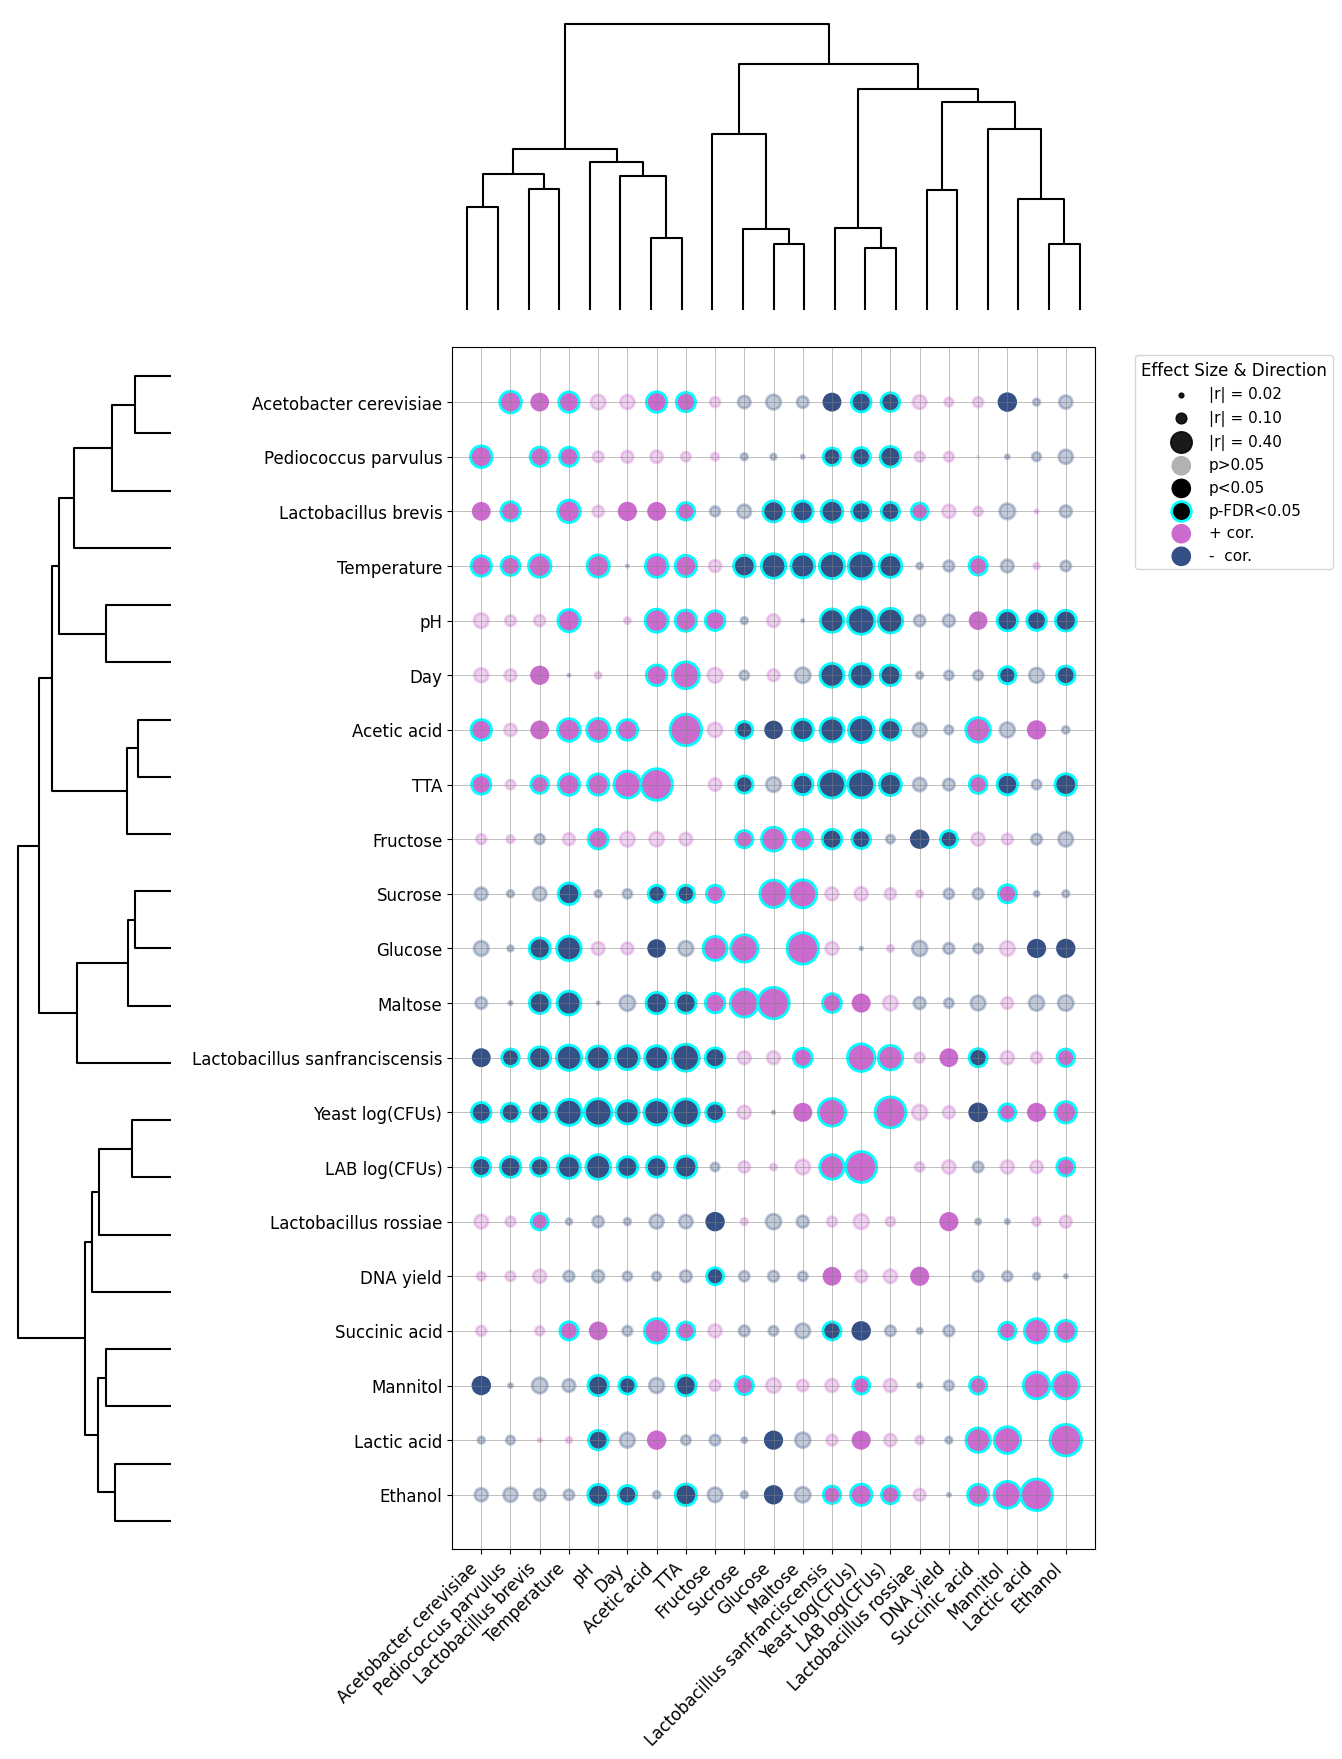

In [75]:
# %matplotlib inline
# plot_clustered_bubbleplot_with_dendrograms(
#     corr_matrix=pearson_corr_matrix,
#     pval_matrix=pearson_pval_matrix,
#     raw_pval_matrix=pearson_raw_pval_matrix,
#     x_vars=['log10_Acetobacter cerevisiae',
#  'log10_Lactobacillus sanfranciscensis',
#  'log10_Pediococcus parvulus',
#  'log10_Lactobacillus rossiae',
#  'log10_Lactobacillus brevis'
 
#     ],
#     y_vars=[
#         'mannitol',
#  'glucose',
#  'fructose',
#  'sucrose',
#  'maltose',
#  'succinic acid',
#  'lactic acid',
#  'acetic acid',
#  'yeast CFUs',
#  'ethanol','LAB CFUs','pH',
#  'TTA','DNA yield','temperature',
#  'day'
#     ],
#     alpha_cutoff=0.05,
#     title="",
#     figsize=(6, 9),
#     max_bubble_size=1500,
#     fontsize=12,
#     rename_dict=rename_dict,
# )

%matplotlib inline
fig = plot_clustered_bubbleplot_with_dendrograms(
    corr_matrix=pearson_corr_matrix,
    pval_matrix=pearson_pval_matrix,
    raw_pval_matrix=pearson_raw_pval_matrix,
    x_vars=['log10_Acetobacter cerevisiae',
 'log10_Lactobacillus sanfranciscensis',
 'log10_Pediococcus parvulus',
 'log10_Lactobacillus rossiae',
 'log10_Lactobacillus brevis',
 'yeast CFUs',
 'mannitol',
 'glucose',
 'fructose',
 'sucrose',
 'maltose',
 'succinic acid',
 'lactic acid',
 'acetic acid',
 'ethanol','LAB CFUs','pH',
 'TTA','DNA yield','temperature',
 'day'
    ],
    y_vars=[
        'log10_Acetobacter cerevisiae',
 'log10_Lactobacillus sanfranciscensis',
 'log10_Pediococcus parvulus',
 'log10_Lactobacillus rossiae',
 'log10_Lactobacillus brevis',
 'yeast CFUs',
 'mannitol',
 'glucose',
 'fructose',
 'sucrose',
 'maltose',
 'succinic acid',
 'lactic acid',
 'acetic acid',
 'ethanol','LAB CFUs','pH',
 'TTA','DNA yield','temperature',
 'day'
    ],
    alpha_cutoff=0.05,
    title="",
    figsize=(14, 20),
    max_bubble_size=600,
    fontsize=12,
    rename_dict=rename_dict,
)
plt.savefig('Figures/20250521_pairwise_correlation_results_CFU_HPLC_pH_TTA_bacterial_species_qPCR.pdf', dpi=300, bbox_inches='tight')
